#Transfer tif to png (done in local, need to be updated in jupyter notebook)
import cv2
import os
import numpy as np

path = os.getcwd()
print(path)

imagesDirectory= os.path.join(path,"sr_data")  # tif image directory
distDirectory = os.path.dirname(imagesDirectory)
distDirectory = os.path.join(distDirectory, "sr_png")# save directory

for imageName in os.listdir(imagesDirectory):
    imagePath = os.path.join(imagesDirectory, imageName)
    image = cv2.imread(imagePath)# open tif image
    img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    distImagePath = os.path.join(distDirectory, imageName[:-4]+'.png')# save imgaes
    cv2.imwrite(distImagePath,img)# write imgaes

In [ ]:
#Traninig

In [6]:
import argparse
import os
import numpy as np
import math
import itertools
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable

from models import *
from datasets import *

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)


epoch=0
n_epochs=200
#dataset_name="img_hr"
batch_size=5
lr=0.0002
b1=0.5
b2=0.999
decay_epoch=100
n_cpu=8
hr_height=512
hr_width=512
channels=1
sample_interval=1
checkpoint_interval=-1

cuda = torch.cuda.is_available()

hr_shape = (hr_height, hr_width)

# Initialize generator and discriminator
generator = GeneratorResNet(in_channels=channels, out_channels=channels)
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

if epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/generator_%d.pth"))
    discriminator.load_state_dict(torch.load("saved_models/discriminator_%d.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

dataloader = DataLoader(
    #ImageDataset("../../data/%s" % opt.dataset_name, hr_shape=hr_shape),
    ImageDataset("../../data/", hr_shape=hr_shape),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

# ----------
#  Training
# ----------

for epoch in range(epoch, n_epochs):
    for i, imgs in enumerate(dataloader):

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)

        # Content loss
    #    gen_features = feature_extractor(gen_hr)
        gen_features = feature_extractor(torch.cat((gen_hr,gen_hr,gen_hr),1))
    #    real_features = feature_extractor(imgs_hr)
        real_features = feature_extractor(torch.cat((imgs_hr,imgs_hr,imgs_hr),1))
    #    loss_content = criterion_content(gen_features, real_features.detach())
        loss_content = criterion_content(gen_hr, imgs_hr.detach()) + criterion_content(gen_features, real_features.detach())

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), loss_D.item(), loss_G.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            # Save image grid with upsampled inputs and SRGAN outputs
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            imgs_hr = make_grid(imgs_hr, nrow=1,normalize=True)
            img_grid = torch.cat((imgs_lr, gen_hr, imgs_hr), -1)
            save_image(img_grid, "images/%d.png" % batches_done, normalize=False)
             #print("batch_done:%d\n" %batches_done)           
    
    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "saved_models/generator_%d.pth" % epoch)
        torch.save(discriminator.state_dict(), "saved_models/discriminator_%d.pth" % epoch)


[Epoch 0/200] [Batch 0/20] [D loss: 0.825969] [G loss: 1.105001][Epoch 0/200] [Batch 1/20] [D loss: 0.537269] [G loss: 0.892158][Epoch 0/200] [Batch 2/20] [D loss: 2.792223] [G loss: 0.482159][Epoch 0/200] [Batch 3/20] [D loss: 1.373746] [G loss: 0.380336][Epoch 0/200] [Batch 4/20] [D loss: 1.753503] [G loss: 0.254721][Epoch 0/200] [Batch 5/20] [D loss: 0.763211] [G loss: 0.189285][Epoch 0/200] [Batch 6/20] [D loss: 0.332758] [G loss: 0.154478][Epoch 0/200] [Batch 7/20] [D loss: 0.291898] [G loss: 0.078880][Epoch 0/200] [Batch 8/20] [D loss: 0.271265] [G loss: 0.167180][Epoch 0/200] [Batch 9/20] [D loss: 0.269648] [G loss: 0.106213][Epoch 0/200] [Batch 10/20] [D loss: 0.271661] [G loss: 0.150824][Epoch 0/200] [Batch 11/20] [D loss: 0.264508] [G loss: 0.111226][Epoch 0/200] [Batch 12/20] [D loss: 0.255513] [G loss: 0.104821][Epoch 0/200] [Batch 13/20] [D loss: 0.237623] [G loss: 0.085114][Epoch 0/200] [Batch 14/20] [D loss: 0.236739] [G loss: 0.118528][Epoch 0/200] [Batch 15/20] [D loss

[Epoch 6/200] [Batch 8/20] [D loss: 0.066820] [G loss: 0.123055][Epoch 6/200] [Batch 9/20] [D loss: 0.059103] [G loss: 0.111185][Epoch 6/200] [Batch 10/20] [D loss: 0.056487] [G loss: 0.075288][Epoch 6/200] [Batch 11/20] [D loss: 0.061055] [G loss: 0.081565][Epoch 6/200] [Batch 12/20] [D loss: 0.198630] [G loss: 0.088907][Epoch 6/200] [Batch 13/20] [D loss: 0.458861] [G loss: 0.108075][Epoch 6/200] [Batch 14/20] [D loss: 0.326889] [G loss: 0.064132][Epoch 6/200] [Batch 15/20] [D loss: 0.180178] [G loss: 0.050039][Epoch 6/200] [Batch 16/20] [D loss: 0.102493] [G loss: 0.088737][Epoch 6/200] [Batch 17/20] [D loss: 0.190379] [G loss: 0.102613][Epoch 6/200] [Batch 18/20] [D loss: 0.159375] [G loss: 0.066735][Epoch 6/200] [Batch 19/20] [D loss: 0.082276] [G loss: 0.059267][Epoch 7/200] [Batch 0/20] [D loss: 0.066096] [G loss: 0.039062][Epoch 7/200] [Batch 1/20] [D loss: 0.077174] [G loss: 0.109520][Epoch 7/200] [Batch 2/20] [D loss: 0.066969] [G loss: 0.092182][Epoch 7/200] [Batch 3/20] [D 

[Epoch 12/200] [Batch 15/20] [D loss: 0.009939] [G loss: 0.105116][Epoch 12/200] [Batch 16/20] [D loss: 0.013379] [G loss: 0.096015][Epoch 12/200] [Batch 17/20] [D loss: 0.008368] [G loss: 0.063732][Epoch 12/200] [Batch 18/20] [D loss: 0.004651] [G loss: 0.082865][Epoch 12/200] [Batch 19/20] [D loss: 0.004619] [G loss: 0.069048][Epoch 13/200] [Batch 0/20] [D loss: 0.004967] [G loss: 0.097748][Epoch 13/200] [Batch 1/20] [D loss: 0.005844] [G loss: 0.069700][Epoch 13/200] [Batch 2/20] [D loss: 0.007823] [G loss: 0.094992][Epoch 13/200] [Batch 3/20] [D loss: 0.012755] [G loss: 0.051565][Epoch 13/200] [Batch 4/20] [D loss: 0.010286] [G loss: 0.070039][Epoch 13/200] [Batch 5/20] [D loss: 0.006829] [G loss: 0.048430][Epoch 13/200] [Batch 6/20] [D loss: 0.013802] [G loss: 0.053187][Epoch 13/200] [Batch 7/20] [D loss: 0.005483] [G loss: 0.100359][Epoch 13/200] [Batch 8/20] [D loss: 0.005475] [G loss: 0.125336][Epoch 13/200] [Batch 9/20] [D loss: 0.005514] [G loss: 0.110973][Epoch 13/200] [Batc

[Epoch 19/200] [Batch 1/20] [D loss: 0.018554] [G loss: 0.079477][Epoch 19/200] [Batch 2/20] [D loss: 0.016578] [G loss: 0.058646][Epoch 19/200] [Batch 3/20] [D loss: 0.073492] [G loss: 0.148724][Epoch 19/200] [Batch 4/20] [D loss: 0.132351] [G loss: 0.117586][Epoch 19/200] [Batch 5/20] [D loss: 0.484890] [G loss: 0.109279][Epoch 19/200] [Batch 6/20] [D loss: 0.749431] [G loss: 0.054470][Epoch 19/200] [Batch 7/20] [D loss: 0.437721] [G loss: 0.051069][Epoch 19/200] [Batch 8/20] [D loss: 0.237960] [G loss: 0.095633][Epoch 19/200] [Batch 9/20] [D loss: 0.080989] [G loss: 0.092985][Epoch 19/200] [Batch 10/20] [D loss: 0.054759] [G loss: 0.098299][Epoch 19/200] [Batch 11/20] [D loss: 0.049639] [G loss: 0.062793][Epoch 19/200] [Batch 12/20] [D loss: 0.025021] [G loss: 0.062731][Epoch 19/200] [Batch 13/20] [D loss: 0.022056] [G loss: 0.084007][Epoch 19/200] [Batch 14/20] [D loss: 0.010846] [G loss: 0.061056][Epoch 19/200] [Batch 15/20] [D loss: 0.010580] [G loss: 0.125563][Epoch 19/200] [Bat

[Epoch 25/200] [Batch 7/20] [D loss: 0.011938] [G loss: 0.109791][Epoch 25/200] [Batch 8/20] [D loss: 0.018587] [G loss: 0.066883][Epoch 25/200] [Batch 9/20] [D loss: 0.017215] [G loss: 0.085983][Epoch 25/200] [Batch 10/20] [D loss: 0.012374] [G loss: 0.084318][Epoch 25/200] [Batch 11/20] [D loss: 0.008648] [G loss: 0.054000][Epoch 25/200] [Batch 12/20] [D loss: 0.015539] [G loss: 0.105238][Epoch 25/200] [Batch 13/20] [D loss: 0.030112] [G loss: 0.090164][Epoch 25/200] [Batch 14/20] [D loss: 0.028085] [G loss: 0.081794][Epoch 25/200] [Batch 15/20] [D loss: 0.013126] [G loss: 0.044084][Epoch 25/200] [Batch 16/20] [D loss: 0.009671] [G loss: 0.118073][Epoch 25/200] [Batch 17/20] [D loss: 0.006551] [G loss: 0.077905][Epoch 25/200] [Batch 18/20] [D loss: 0.005023] [G loss: 0.071377][Epoch 25/200] [Batch 19/20] [D loss: 0.006723] [G loss: 0.106120][Epoch 26/200] [Batch 0/20] [D loss: 0.033179] [G loss: 0.125921][Epoch 26/200] [Batch 1/20] [D loss: 0.023439] [G loss: 0.066267][Epoch 26/200] 

[Epoch 31/200] [Batch 13/20] [D loss: 0.003009] [G loss: 0.074836][Epoch 31/200] [Batch 14/20] [D loss: 0.003808] [G loss: 0.066658][Epoch 31/200] [Batch 15/20] [D loss: 0.005484] [G loss: 0.085956][Epoch 31/200] [Batch 16/20] [D loss: 0.007904] [G loss: 0.077868][Epoch 31/200] [Batch 17/20] [D loss: 0.004546] [G loss: 0.076305][Epoch 31/200] [Batch 18/20] [D loss: 0.002495] [G loss: 0.071110][Epoch 31/200] [Batch 19/20] [D loss: 0.003257] [G loss: 0.086851][Epoch 32/200] [Batch 0/20] [D loss: 0.002691] [G loss: 0.067611][Epoch 32/200] [Batch 1/20] [D loss: 0.001231] [G loss: 0.062947][Epoch 32/200] [Batch 2/20] [D loss: 0.001569] [G loss: 0.069761][Epoch 32/200] [Batch 3/20] [D loss: 0.002410] [G loss: 0.116362][Epoch 32/200] [Batch 4/20] [D loss: 0.000956] [G loss: 0.086738][Epoch 32/200] [Batch 5/20] [D loss: 0.006805] [G loss: 0.053316][Epoch 32/200] [Batch 6/20] [D loss: 0.003597] [G loss: 0.061090][Epoch 32/200] [Batch 7/20] [D loss: 0.001973] [G loss: 0.080218][Epoch 32/200] [Ba

[Epoch 37/200] [Batch 19/20] [D loss: 0.010229] [G loss: 0.045739][Epoch 38/200] [Batch 0/20] [D loss: 0.016579] [G loss: 0.126496][Epoch 38/200] [Batch 1/20] [D loss: 0.009156] [G loss: 0.068463][Epoch 38/200] [Batch 2/20] [D loss: 0.006501] [G loss: 0.060925][Epoch 38/200] [Batch 3/20] [D loss: 0.002870] [G loss: 0.046572][Epoch 38/200] [Batch 4/20] [D loss: 0.012372] [G loss: 0.126388][Epoch 38/200] [Batch 5/20] [D loss: 0.014443] [G loss: 0.060679][Epoch 38/200] [Batch 6/20] [D loss: 0.007372] [G loss: 0.074973][Epoch 38/200] [Batch 7/20] [D loss: 0.004188] [G loss: 0.033184][Epoch 38/200] [Batch 8/20] [D loss: 0.007576] [G loss: 0.081536][Epoch 38/200] [Batch 9/20] [D loss: 0.003875] [G loss: 0.118825][Epoch 38/200] [Batch 10/20] [D loss: 0.003793] [G loss: 0.047394][Epoch 38/200] [Batch 11/20] [D loss: 0.002089] [G loss: 0.117994][Epoch 38/200] [Batch 12/20] [D loss: 0.003302] [G loss: 0.092321][Epoch 38/200] [Batch 13/20] [D loss: 0.003260] [G loss: 0.075358][Epoch 38/200] [Batc

[Epoch 44/200] [Batch 5/20] [D loss: 0.001690] [G loss: 0.053469][Epoch 44/200] [Batch 6/20] [D loss: 0.003160] [G loss: 0.113330][Epoch 44/200] [Batch 7/20] [D loss: 0.001827] [G loss: 0.069176][Epoch 44/200] [Batch 8/20] [D loss: 0.000979] [G loss: 0.127893][Epoch 44/200] [Batch 9/20] [D loss: 0.001261] [G loss: 0.070535][Epoch 44/200] [Batch 10/20] [D loss: 0.001241] [G loss: 0.122418][Epoch 44/200] [Batch 11/20] [D loss: 0.000985] [G loss: 0.088331][Epoch 44/200] [Batch 12/20] [D loss: 0.001089] [G loss: 0.054918][Epoch 44/200] [Batch 13/20] [D loss: 0.003716] [G loss: 0.078432][Epoch 44/200] [Batch 14/20] [D loss: 0.003178] [G loss: 0.059095][Epoch 44/200] [Batch 15/20] [D loss: 0.001241] [G loss: 0.084516][Epoch 44/200] [Batch 16/20] [D loss: 0.001330] [G loss: 0.108778][Epoch 44/200] [Batch 17/20] [D loss: 0.001227] [G loss: 0.076495][Epoch 44/200] [Batch 18/20] [D loss: 0.000958] [G loss: 0.048354][Epoch 44/200] [Batch 19/20] [D loss: 0.000825] [G loss: 0.069334][Epoch 45/200] 

[Epoch 50/200] [Batch 11/20] [D loss: 0.003322] [G loss: 0.062200][Epoch 50/200] [Batch 12/20] [D loss: 0.010305] [G loss: 0.132459][Epoch 50/200] [Batch 13/20] [D loss: 0.009185] [G loss: 0.065656][Epoch 50/200] [Batch 14/20] [D loss: 0.001494] [G loss: 0.053989][Epoch 50/200] [Batch 15/20] [D loss: 0.004574] [G loss: 0.089283][Epoch 50/200] [Batch 16/20] [D loss: 0.003759] [G loss: 0.110855][Epoch 50/200] [Batch 17/20] [D loss: 0.002841] [G loss: 0.043905][Epoch 50/200] [Batch 18/20] [D loss: 0.012057] [G loss: 0.089076][Epoch 50/200] [Batch 19/20] [D loss: 0.011168] [G loss: 0.094641][Epoch 51/200] [Batch 0/20] [D loss: 0.009989] [G loss: 0.058705][Epoch 51/200] [Batch 1/20] [D loss: 0.006128] [G loss: 0.106569][Epoch 51/200] [Batch 2/20] [D loss: 0.005216] [G loss: 0.113342][Epoch 51/200] [Batch 3/20] [D loss: 0.003319] [G loss: 0.064180][Epoch 51/200] [Batch 4/20] [D loss: 0.002163] [G loss: 0.053257][Epoch 51/200] [Batch 5/20] [D loss: 0.001604] [G loss: 0.054422][Epoch 51/200] [

[Epoch 56/200] [Batch 17/20] [D loss: 0.000950] [G loss: 0.063873][Epoch 56/200] [Batch 18/20] [D loss: 0.000886] [G loss: 0.061361][Epoch 56/200] [Batch 19/20] [D loss: 0.001111] [G loss: 0.071548][Epoch 57/200] [Batch 0/20] [D loss: 0.001591] [G loss: 0.132222][Epoch 57/200] [Batch 1/20] [D loss: 0.003816] [G loss: 0.101448][Epoch 57/200] [Batch 2/20] [D loss: 0.005527] [G loss: 0.062024][Epoch 57/200] [Batch 3/20] [D loss: 0.002274] [G loss: 0.070775][Epoch 57/200] [Batch 4/20] [D loss: 0.001385] [G loss: 0.086536][Epoch 57/200] [Batch 5/20] [D loss: 0.001759] [G loss: 0.061850][Epoch 57/200] [Batch 6/20] [D loss: 0.001065] [G loss: 0.069640][Epoch 57/200] [Batch 7/20] [D loss: 0.002803] [G loss: 0.084720][Epoch 57/200] [Batch 8/20] [D loss: 0.003936] [G loss: 0.083228][Epoch 57/200] [Batch 9/20] [D loss: 0.005428] [G loss: 0.089791][Epoch 57/200] [Batch 10/20] [D loss: 0.004461] [G loss: 0.060351][Epoch 57/200] [Batch 11/20] [D loss: 0.003706] [G loss: 0.063699][Epoch 57/200] [Batc

[Epoch 63/200] [Batch 3/20] [D loss: 0.002950] [G loss: 0.055717][Epoch 63/200] [Batch 4/20] [D loss: 0.001956] [G loss: 0.094922][Epoch 63/200] [Batch 5/20] [D loss: 0.000945] [G loss: 0.085810][Epoch 63/200] [Batch 6/20] [D loss: 0.000619] [G loss: 0.106438][Epoch 63/200] [Batch 7/20] [D loss: 0.001855] [G loss: 0.075582][Epoch 63/200] [Batch 8/20] [D loss: 0.000724] [G loss: 0.082150][Epoch 63/200] [Batch 9/20] [D loss: 0.001344] [G loss: 0.068273][Epoch 63/200] [Batch 10/20] [D loss: 0.001223] [G loss: 0.113004][Epoch 63/200] [Batch 11/20] [D loss: 0.000743] [G loss: 0.062265][Epoch 63/200] [Batch 12/20] [D loss: 0.000805] [G loss: 0.089934][Epoch 63/200] [Batch 13/20] [D loss: 0.004528] [G loss: 0.088287][Epoch 63/200] [Batch 14/20] [D loss: 0.010473] [G loss: 0.058006][Epoch 63/200] [Batch 15/20] [D loss: 0.005174] [G loss: 0.058784][Epoch 63/200] [Batch 16/20] [D loss: 0.004818] [G loss: 0.063468][Epoch 63/200] [Batch 17/20] [D loss: 0.017628] [G loss: 0.071416][Epoch 63/200] [B

[Epoch 69/200] [Batch 9/20] [D loss: 0.011486] [G loss: 0.071354][Epoch 69/200] [Batch 10/20] [D loss: 0.010271] [G loss: 0.075381][Epoch 69/200] [Batch 11/20] [D loss: 0.017994] [G loss: 0.085925][Epoch 69/200] [Batch 12/20] [D loss: 0.025601] [G loss: 0.083024][Epoch 69/200] [Batch 13/20] [D loss: 0.011777] [G loss: 0.067041][Epoch 69/200] [Batch 14/20] [D loss: 0.007006] [G loss: 0.065936][Epoch 69/200] [Batch 15/20] [D loss: 0.011778] [G loss: 0.058830][Epoch 69/200] [Batch 16/20] [D loss: 0.006774] [G loss: 0.074860][Epoch 69/200] [Batch 17/20] [D loss: 0.004070] [G loss: 0.064017][Epoch 69/200] [Batch 18/20] [D loss: 0.005098] [G loss: 0.074926][Epoch 69/200] [Batch 19/20] [D loss: 0.009391] [G loss: 0.078187][Epoch 70/200] [Batch 0/20] [D loss: 0.006502] [G loss: 0.090063][Epoch 70/200] [Batch 1/20] [D loss: 0.013748] [G loss: 0.084421][Epoch 70/200] [Batch 2/20] [D loss: 0.011573] [G loss: 0.092894][Epoch 70/200] [Batch 3/20] [D loss: 0.004820] [G loss: 0.090158][Epoch 70/200] 

[Epoch 75/200] [Batch 15/20] [D loss: 0.001966] [G loss: 0.059725][Epoch 75/200] [Batch 16/20] [D loss: 0.002584] [G loss: 0.048706][Epoch 75/200] [Batch 17/20] [D loss: 0.012253] [G loss: 0.093761][Epoch 75/200] [Batch 18/20] [D loss: 0.011659] [G loss: 0.082406][Epoch 75/200] [Batch 19/20] [D loss: 0.011335] [G loss: 0.070824][Epoch 76/200] [Batch 0/20] [D loss: 0.013875] [G loss: 0.065814][Epoch 76/200] [Batch 1/20] [D loss: 0.012901] [G loss: 0.081616][Epoch 76/200] [Batch 2/20] [D loss: 0.005038] [G loss: 0.072691][Epoch 76/200] [Batch 3/20] [D loss: 0.007605] [G loss: 0.060248][Epoch 76/200] [Batch 4/20] [D loss: 0.004149] [G loss: 0.089202][Epoch 76/200] [Batch 5/20] [D loss: 0.006464] [G loss: 0.103119][Epoch 76/200] [Batch 6/20] [D loss: 0.026079] [G loss: 0.052291][Epoch 76/200] [Batch 7/20] [D loss: 0.006055] [G loss: 0.083841][Epoch 76/200] [Batch 8/20] [D loss: 0.012041] [G loss: 0.105652][Epoch 76/200] [Batch 9/20] [D loss: 0.011579] [G loss: 0.075432][Epoch 76/200] [Batc

[Epoch 82/200] [Batch 1/20] [D loss: 0.010107] [G loss: 0.039233][Epoch 82/200] [Batch 2/20] [D loss: 0.003309] [G loss: 0.069011][Epoch 82/200] [Batch 3/20] [D loss: 0.011191] [G loss: 0.138798][Epoch 82/200] [Batch 4/20] [D loss: 0.008537] [G loss: 0.121656][Epoch 82/200] [Batch 5/20] [D loss: 0.008723] [G loss: 0.044867][Epoch 82/200] [Batch 6/20] [D loss: 0.002799] [G loss: 0.106311][Epoch 82/200] [Batch 7/20] [D loss: 0.001310] [G loss: 0.060182][Epoch 82/200] [Batch 8/20] [D loss: 0.001599] [G loss: 0.059912][Epoch 82/200] [Batch 9/20] [D loss: 0.001918] [G loss: 0.050611][Epoch 82/200] [Batch 10/20] [D loss: 0.004057] [G loss: 0.061638][Epoch 82/200] [Batch 11/20] [D loss: 0.001787] [G loss: 0.060569][Epoch 82/200] [Batch 12/20] [D loss: 0.013499] [G loss: 0.079392][Epoch 82/200] [Batch 13/20] [D loss: 0.027400] [G loss: 0.085825][Epoch 82/200] [Batch 14/20] [D loss: 0.029362] [G loss: 0.072052][Epoch 82/200] [Batch 15/20] [D loss: 0.007971] [G loss: 0.102115][Epoch 82/200] [Bat

[Epoch 88/200] [Batch 7/20] [D loss: 0.000713] [G loss: 0.102745][Epoch 88/200] [Batch 8/20] [D loss: 0.003414] [G loss: 0.070603][Epoch 88/200] [Batch 9/20] [D loss: 0.004362] [G loss: 0.064006][Epoch 88/200] [Batch 10/20] [D loss: 0.003816] [G loss: 0.052184][Epoch 88/200] [Batch 11/20] [D loss: 0.001362] [G loss: 0.062381][Epoch 88/200] [Batch 12/20] [D loss: 0.006265] [G loss: 0.073384][Epoch 88/200] [Batch 13/20] [D loss: 0.020844] [G loss: 0.054401][Epoch 88/200] [Batch 14/20] [D loss: 0.008257] [G loss: 0.110933][Epoch 88/200] [Batch 15/20] [D loss: 0.005651] [G loss: 0.076801][Epoch 88/200] [Batch 16/20] [D loss: 0.003800] [G loss: 0.057065][Epoch 88/200] [Batch 17/20] [D loss: 0.010747] [G loss: 0.068947][Epoch 88/200] [Batch 18/20] [D loss: 0.004573] [G loss: 0.059784][Epoch 88/200] [Batch 19/20] [D loss: 0.004574] [G loss: 0.058485][Epoch 89/200] [Batch 0/20] [D loss: 0.005451] [G loss: 0.078098][Epoch 89/200] [Batch 1/20] [D loss: 0.005628] [G loss: 0.045676][Epoch 89/200] 

[Epoch 94/200] [Batch 13/20] [D loss: 0.005515] [G loss: 0.102081][Epoch 94/200] [Batch 14/20] [D loss: 0.001504] [G loss: 0.136436][Epoch 94/200] [Batch 15/20] [D loss: 0.009792] [G loss: 0.063643][Epoch 94/200] [Batch 16/20] [D loss: 0.005742] [G loss: 0.053153][Epoch 94/200] [Batch 17/20] [D loss: 0.005788] [G loss: 0.044042][Epoch 94/200] [Batch 18/20] [D loss: 0.002680] [G loss: 0.058864][Epoch 94/200] [Batch 19/20] [D loss: 0.001817] [G loss: 0.066301][Epoch 95/200] [Batch 0/20] [D loss: 0.003701] [G loss: 0.053806][Epoch 95/200] [Batch 1/20] [D loss: 0.008984] [G loss: 0.066587][Epoch 95/200] [Batch 2/20] [D loss: 0.007840] [G loss: 0.058146][Epoch 95/200] [Batch 3/20] [D loss: 0.002269] [G loss: 0.093665][Epoch 95/200] [Batch 4/20] [D loss: 0.000533] [G loss: 0.061396][Epoch 95/200] [Batch 5/20] [D loss: 0.003252] [G loss: 0.094380][Epoch 95/200] [Batch 6/20] [D loss: 0.004646] [G loss: 0.042718][Epoch 95/200] [Batch 7/20] [D loss: 0.003147] [G loss: 0.094232][Epoch 95/200] [Ba

[Epoch 100/200] [Batch 18/20] [D loss: 0.016767] [G loss: 0.054470][Epoch 100/200] [Batch 19/20] [D loss: 0.012819] [G loss: 0.107878][Epoch 101/200] [Batch 0/20] [D loss: 0.015545] [G loss: 0.068356][Epoch 101/200] [Batch 1/20] [D loss: 0.014208] [G loss: 0.071449][Epoch 101/200] [Batch 2/20] [D loss: 0.018803] [G loss: 0.055622][Epoch 101/200] [Batch 3/20] [D loss: 0.017581] [G loss: 0.054544][Epoch 101/200] [Batch 4/20] [D loss: 0.004672] [G loss: 0.126167][Epoch 101/200] [Batch 5/20] [D loss: 0.002954] [G loss: 0.073403][Epoch 101/200] [Batch 6/20] [D loss: 0.006779] [G loss: 0.031068][Epoch 101/200] [Batch 7/20] [D loss: 0.007735] [G loss: 0.051987][Epoch 101/200] [Batch 8/20] [D loss: 0.007443] [G loss: 0.086354][Epoch 101/200] [Batch 9/20] [D loss: 0.003063] [G loss: 0.055962][Epoch 101/200] [Batch 10/20] [D loss: 0.004395] [G loss: 0.063366][Epoch 101/200] [Batch 11/20] [D loss: 0.003408] [G loss: 0.061510][Epoch 101/200] [Batch 12/20] [D loss: 0.003724] [G loss: 0.097247][Epoc

[Epoch 107/200] [Batch 2/20] [D loss: 0.005686] [G loss: 0.030956][Epoch 107/200] [Batch 3/20] [D loss: 0.009790] [G loss: 0.079706][Epoch 107/200] [Batch 4/20] [D loss: 0.011130] [G loss: 0.077220][Epoch 107/200] [Batch 5/20] [D loss: 0.023392] [G loss: 0.038293][Epoch 107/200] [Batch 6/20] [D loss: 0.019606] [G loss: 0.074259][Epoch 107/200] [Batch 7/20] [D loss: 0.003960] [G loss: 0.056290][Epoch 107/200] [Batch 8/20] [D loss: 0.012611] [G loss: 0.068590][Epoch 107/200] [Batch 9/20] [D loss: 0.007718] [G loss: 0.046388][Epoch 107/200] [Batch 10/20] [D loss: 0.002648] [G loss: 0.084088][Epoch 107/200] [Batch 11/20] [D loss: 0.014871] [G loss: 0.083893][Epoch 107/200] [Batch 12/20] [D loss: 0.011063] [G loss: 0.055934][Epoch 107/200] [Batch 13/20] [D loss: 0.007171] [G loss: 0.077474][Epoch 107/200] [Batch 14/20] [D loss: 0.003969] [G loss: 0.061955][Epoch 107/200] [Batch 15/20] [D loss: 0.004341] [G loss: 0.060172][Epoch 107/200] [Batch 16/20] [D loss: 0.011124] [G loss: 0.126202][Ep

[Epoch 113/200] [Batch 6/20] [D loss: 0.002478] [G loss: 0.085815][Epoch 113/200] [Batch 7/20] [D loss: 0.002636] [G loss: 0.080347][Epoch 113/200] [Batch 8/20] [D loss: 0.002989] [G loss: 0.041225][Epoch 113/200] [Batch 9/20] [D loss: 0.003162] [G loss: 0.085236][Epoch 113/200] [Batch 10/20] [D loss: 0.002378] [G loss: 0.051648][Epoch 113/200] [Batch 11/20] [D loss: 0.003767] [G loss: 0.068261][Epoch 113/200] [Batch 12/20] [D loss: 0.015874] [G loss: 0.036249][Epoch 113/200] [Batch 13/20] [D loss: 0.040143] [G loss: 0.043121][Epoch 113/200] [Batch 14/20] [D loss: 0.010789] [G loss: 0.058047][Epoch 113/200] [Batch 15/20] [D loss: 0.064924] [G loss: 0.054546][Epoch 113/200] [Batch 16/20] [D loss: 0.034448] [G loss: 0.092737][Epoch 113/200] [Batch 17/20] [D loss: 0.037015] [G loss: 0.055546][Epoch 113/200] [Batch 18/20] [D loss: 0.031662] [G loss: 0.077831][Epoch 113/200] [Batch 19/20] [D loss: 0.022731] [G loss: 0.105826][Epoch 114/200] [Batch 0/20] [D loss: 0.013374] [G loss: 0.056574]

[Epoch 119/200] [Batch 10/20] [D loss: 0.129146] [G loss: 0.062410][Epoch 119/200] [Batch 11/20] [D loss: 0.022459] [G loss: 0.086712][Epoch 119/200] [Batch 12/20] [D loss: 0.053115] [G loss: 0.061081][Epoch 119/200] [Batch 13/20] [D loss: 0.042127] [G loss: 0.074578][Epoch 119/200] [Batch 14/20] [D loss: 0.010742] [G loss: 0.046484][Epoch 119/200] [Batch 15/20] [D loss: 0.031650] [G loss: 0.046732][Epoch 119/200] [Batch 16/20] [D loss: 0.124456] [G loss: 0.061993][Epoch 119/200] [Batch 17/20] [D loss: 0.122302] [G loss: 0.073964][Epoch 119/200] [Batch 18/20] [D loss: 0.370864] [G loss: 0.051547][Epoch 119/200] [Batch 19/20] [D loss: 0.212138] [G loss: 0.049283][Epoch 120/200] [Batch 0/20] [D loss: 0.078707] [G loss: 0.057377][Epoch 120/200] [Batch 1/20] [D loss: 0.034955] [G loss: 0.072690][Epoch 120/200] [Batch 2/20] [D loss: 0.020574] [G loss: 0.072456][Epoch 120/200] [Batch 3/20] [D loss: 0.050199] [G loss: 0.049594][Epoch 120/200] [Batch 4/20] [D loss: 0.011221] [G loss: 0.082342]

[Epoch 125/200] [Batch 14/20] [D loss: 0.002261] [G loss: 0.063875][Epoch 125/200] [Batch 15/20] [D loss: 0.006735] [G loss: 0.083864][Epoch 125/200] [Batch 16/20] [D loss: 0.004363] [G loss: 0.054159][Epoch 125/200] [Batch 17/20] [D loss: 0.002786] [G loss: 0.063868][Epoch 125/200] [Batch 18/20] [D loss: 0.001641] [G loss: 0.089224][Epoch 125/200] [Batch 19/20] [D loss: 0.003480] [G loss: 0.066076][Epoch 126/200] [Batch 0/20] [D loss: 0.002819] [G loss: 0.056413][Epoch 126/200] [Batch 1/20] [D loss: 0.008101] [G loss: 0.060199][Epoch 126/200] [Batch 2/20] [D loss: 0.006953] [G loss: 0.065735][Epoch 126/200] [Batch 3/20] [D loss: 0.003631] [G loss: 0.052300][Epoch 126/200] [Batch 4/20] [D loss: 0.001166] [G loss: 0.063220][Epoch 126/200] [Batch 5/20] [D loss: 0.003178] [G loss: 0.065642][Epoch 126/200] [Batch 6/20] [D loss: 0.005512] [G loss: 0.053612][Epoch 126/200] [Batch 7/20] [D loss: 0.001970] [G loss: 0.058496][Epoch 126/200] [Batch 8/20] [D loss: 0.001125] [G loss: 0.042545][Epo

[Epoch 131/200] [Batch 18/20] [D loss: 0.001109] [G loss: 0.079155][Epoch 131/200] [Batch 19/20] [D loss: 0.004401] [G loss: 0.059966][Epoch 132/200] [Batch 0/20] [D loss: 0.001279] [G loss: 0.065307][Epoch 132/200] [Batch 1/20] [D loss: 0.001132] [G loss: 0.089759][Epoch 132/200] [Batch 2/20] [D loss: 0.000759] [G loss: 0.063750][Epoch 132/200] [Batch 3/20] [D loss: 0.000482] [G loss: 0.048367][Epoch 132/200] [Batch 4/20] [D loss: 0.001095] [G loss: 0.065138][Epoch 132/200] [Batch 5/20] [D loss: 0.002989] [G loss: 0.050128][Epoch 132/200] [Batch 6/20] [D loss: 0.002443] [G loss: 0.059361][Epoch 132/200] [Batch 7/20] [D loss: 0.002852] [G loss: 0.124030][Epoch 132/200] [Batch 8/20] [D loss: 0.002729] [G loss: 0.060218][Epoch 132/200] [Batch 9/20] [D loss: 0.001849] [G loss: 0.057538][Epoch 132/200] [Batch 10/20] [D loss: 0.001580] [G loss: 0.076892][Epoch 132/200] [Batch 11/20] [D loss: 0.000833] [G loss: 0.064035][Epoch 132/200] [Batch 12/20] [D loss: 0.001110] [G loss: 0.051276][Epoc

[Epoch 138/200] [Batch 2/20] [D loss: 0.001954] [G loss: 0.093592][Epoch 138/200] [Batch 3/20] [D loss: 0.001482] [G loss: 0.063915][Epoch 138/200] [Batch 4/20] [D loss: 0.001333] [G loss: 0.034846][Epoch 138/200] [Batch 5/20] [D loss: 0.000954] [G loss: 0.106082][Epoch 138/200] [Batch 6/20] [D loss: 0.002728] [G loss: 0.051830][Epoch 138/200] [Batch 7/20] [D loss: 0.001201] [G loss: 0.036173][Epoch 138/200] [Batch 8/20] [D loss: 0.000851] [G loss: 0.051400][Epoch 138/200] [Batch 9/20] [D loss: 0.001759] [G loss: 0.056075][Epoch 138/200] [Batch 10/20] [D loss: 0.001557] [G loss: 0.052240][Epoch 138/200] [Batch 11/20] [D loss: 0.001938] [G loss: 0.085309][Epoch 138/200] [Batch 12/20] [D loss: 0.002460] [G loss: 0.044358][Epoch 138/200] [Batch 13/20] [D loss: 0.002777] [G loss: 0.055593][Epoch 138/200] [Batch 14/20] [D loss: 0.003575] [G loss: 0.071115][Epoch 138/200] [Batch 15/20] [D loss: 0.003621] [G loss: 0.045719][Epoch 138/200] [Batch 16/20] [D loss: 0.001183] [G loss: 0.080078][Ep

[Epoch 144/200] [Batch 6/20] [D loss: 0.010476] [G loss: 0.049113][Epoch 144/200] [Batch 7/20] [D loss: 0.009399] [G loss: 0.059775][Epoch 144/200] [Batch 8/20] [D loss: 0.005542] [G loss: 0.083353][Epoch 144/200] [Batch 9/20] [D loss: 0.001485] [G loss: 0.058516][Epoch 144/200] [Batch 10/20] [D loss: 0.001440] [G loss: 0.039153][Epoch 144/200] [Batch 11/20] [D loss: 0.000909] [G loss: 0.031899][Epoch 144/200] [Batch 12/20] [D loss: 0.001246] [G loss: 0.049265][Epoch 144/200] [Batch 13/20] [D loss: 0.000933] [G loss: 0.072961][Epoch 144/200] [Batch 14/20] [D loss: 0.002431] [G loss: 0.045215][Epoch 144/200] [Batch 15/20] [D loss: 0.001153] [G loss: 0.076524][Epoch 144/200] [Batch 16/20] [D loss: 0.003451] [G loss: 0.042350][Epoch 144/200] [Batch 17/20] [D loss: 0.000921] [G loss: 0.051242][Epoch 144/200] [Batch 18/20] [D loss: 0.001044] [G loss: 0.059260][Epoch 144/200] [Batch 19/20] [D loss: 0.002285] [G loss: 0.070139][Epoch 145/200] [Batch 0/20] [D loss: 0.000437] [G loss: 0.074060]

[Epoch 150/200] [Batch 10/20] [D loss: 0.000814] [G loss: 0.081681][Epoch 150/200] [Batch 11/20] [D loss: 0.001284] [G loss: 0.055259][Epoch 150/200] [Batch 12/20] [D loss: 0.003206] [G loss: 0.040425][Epoch 150/200] [Batch 13/20] [D loss: 0.002337] [G loss: 0.052221][Epoch 150/200] [Batch 14/20] [D loss: 0.002956] [G loss: 0.028888][Epoch 150/200] [Batch 15/20] [D loss: 0.001386] [G loss: 0.070124][Epoch 150/200] [Batch 16/20] [D loss: 0.001779] [G loss: 0.037688][Epoch 150/200] [Batch 17/20] [D loss: 0.006098] [G loss: 0.049032][Epoch 150/200] [Batch 18/20] [D loss: 0.003943] [G loss: 0.052832][Epoch 150/200] [Batch 19/20] [D loss: 0.003448] [G loss: 0.075732][Epoch 151/200] [Batch 0/20] [D loss: 0.006225] [G loss: 0.038410][Epoch 151/200] [Batch 1/20] [D loss: 0.013099] [G loss: 0.062021][Epoch 151/200] [Batch 2/20] [D loss: 0.005965] [G loss: 0.103389][Epoch 151/200] [Batch 3/20] [D loss: 0.004507] [G loss: 0.067537][Epoch 151/200] [Batch 4/20] [D loss: 0.002685] [G loss: 0.048098]

[Epoch 156/200] [Batch 14/20] [D loss: 0.001643] [G loss: 0.049880][Epoch 156/200] [Batch 15/20] [D loss: 0.003368] [G loss: 0.069917][Epoch 156/200] [Batch 16/20] [D loss: 0.003474] [G loss: 0.095362][Epoch 156/200] [Batch 17/20] [D loss: 0.003652] [G loss: 0.046161][Epoch 156/200] [Batch 18/20] [D loss: 0.002462] [G loss: 0.047775][Epoch 156/200] [Batch 19/20] [D loss: 0.001715] [G loss: 0.046863][Epoch 157/200] [Batch 0/20] [D loss: 0.000518] [G loss: 0.063646][Epoch 157/200] [Batch 1/20] [D loss: 0.001088] [G loss: 0.053917][Epoch 157/200] [Batch 2/20] [D loss: 0.001207] [G loss: 0.054403][Epoch 157/200] [Batch 3/20] [D loss: 0.002104] [G loss: 0.068869][Epoch 157/200] [Batch 4/20] [D loss: 0.006073] [G loss: 0.050151][Epoch 157/200] [Batch 5/20] [D loss: 0.002618] [G loss: 0.073477][Epoch 157/200] [Batch 6/20] [D loss: 0.005423] [G loss: 0.036628][Epoch 157/200] [Batch 7/20] [D loss: 0.007102] [G loss: 0.047279][Epoch 157/200] [Batch 8/20] [D loss: 0.006735] [G loss: 0.091007][Epo

[Epoch 162/200] [Batch 18/20] [D loss: 0.002341] [G loss: 0.039926][Epoch 162/200] [Batch 19/20] [D loss: 0.002958] [G loss: 0.051532][Epoch 163/200] [Batch 0/20] [D loss: 0.000626] [G loss: 0.100478][Epoch 163/200] [Batch 1/20] [D loss: 0.003988] [G loss: 0.060666][Epoch 163/200] [Batch 2/20] [D loss: 0.002984] [G loss: 0.045212][Epoch 163/200] [Batch 3/20] [D loss: 0.002993] [G loss: 0.066379][Epoch 163/200] [Batch 4/20] [D loss: 0.002351] [G loss: 0.046164][Epoch 163/200] [Batch 5/20] [D loss: 0.002483] [G loss: 0.049445][Epoch 163/200] [Batch 6/20] [D loss: 0.004093] [G loss: 0.047919][Epoch 163/200] [Batch 7/20] [D loss: 0.004320] [G loss: 0.052238][Epoch 163/200] [Batch 8/20] [D loss: 0.002603] [G loss: 0.041484][Epoch 163/200] [Batch 9/20] [D loss: 0.000605] [G loss: 0.077554][Epoch 163/200] [Batch 10/20] [D loss: 0.001852] [G loss: 0.050892][Epoch 163/200] [Batch 11/20] [D loss: 0.001236] [G loss: 0.059789][Epoch 163/200] [Batch 12/20] [D loss: 0.001927] [G loss: 0.081031][Epoc

[Epoch 169/200] [Batch 2/20] [D loss: 0.013885] [G loss: 0.171397][Epoch 169/200] [Batch 3/20] [D loss: 0.007912] [G loss: 0.173283][Epoch 169/200] [Batch 4/20] [D loss: 0.004920] [G loss: 0.079165][Epoch 169/200] [Batch 5/20] [D loss: 0.003127] [G loss: 0.082626][Epoch 169/200] [Batch 6/20] [D loss: 0.003844] [G loss: 0.060263][Epoch 169/200] [Batch 7/20] [D loss: 0.010759] [G loss: 0.145738][Epoch 169/200] [Batch 8/20] [D loss: 0.015110] [G loss: 0.072205][Epoch 169/200] [Batch 9/20] [D loss: 0.010435] [G loss: 0.048503][Epoch 169/200] [Batch 10/20] [D loss: 0.011781] [G loss: 0.100275][Epoch 169/200] [Batch 11/20] [D loss: 0.005434] [G loss: 0.088280][Epoch 169/200] [Batch 12/20] [D loss: 0.002990] [G loss: 0.099023][Epoch 169/200] [Batch 13/20] [D loss: 0.004231] [G loss: 0.164417][Epoch 169/200] [Batch 14/20] [D loss: 0.011229] [G loss: 0.095255][Epoch 169/200] [Batch 15/20] [D loss: 0.007354] [G loss: 0.088259][Epoch 169/200] [Batch 16/20] [D loss: 0.006125] [G loss: 0.109837][Ep

[Epoch 175/200] [Batch 6/20] [D loss: 0.006060] [G loss: 0.065698][Epoch 175/200] [Batch 7/20] [D loss: 0.006500] [G loss: 0.092882][Epoch 175/200] [Batch 8/20] [D loss: 0.001808] [G loss: 0.106805][Epoch 175/200] [Batch 9/20] [D loss: 0.002051] [G loss: 0.079383][Epoch 175/200] [Batch 10/20] [D loss: 0.002910] [G loss: 0.051974][Epoch 175/200] [Batch 11/20] [D loss: 0.003203] [G loss: 0.094146][Epoch 175/200] [Batch 12/20] [D loss: 0.002845] [G loss: 0.109527][Epoch 175/200] [Batch 13/20] [D loss: 0.001343] [G loss: 0.121731][Epoch 175/200] [Batch 14/20] [D loss: 0.001981] [G loss: 0.071244][Epoch 175/200] [Batch 15/20] [D loss: 0.001176] [G loss: 0.069000][Epoch 175/200] [Batch 16/20] [D loss: 0.001991] [G loss: 0.056140][Epoch 175/200] [Batch 17/20] [D loss: 0.003183] [G loss: 0.074548][Epoch 175/200] [Batch 18/20] [D loss: 0.002932] [G loss: 0.054595][Epoch 175/200] [Batch 19/20] [D loss: 0.002251] [G loss: 0.099093][Epoch 176/200] [Batch 0/20] [D loss: 0.001522] [G loss: 0.040253]

[Epoch 181/200] [Batch 10/20] [D loss: 0.004997] [G loss: 0.102145][Epoch 181/200] [Batch 11/20] [D loss: 0.006803] [G loss: 0.073741][Epoch 181/200] [Batch 12/20] [D loss: 0.003877] [G loss: 0.051555][Epoch 181/200] [Batch 13/20] [D loss: 0.002748] [G loss: 0.080243][Epoch 181/200] [Batch 14/20] [D loss: 0.002401] [G loss: 0.117858][Epoch 181/200] [Batch 15/20] [D loss: 0.003923] [G loss: 0.055025][Epoch 181/200] [Batch 16/20] [D loss: 0.002689] [G loss: 0.080346][Epoch 181/200] [Batch 17/20] [D loss: 0.002464] [G loss: 0.051456][Epoch 181/200] [Batch 18/20] [D loss: 0.002618] [G loss: 0.065108][Epoch 181/200] [Batch 19/20] [D loss: 0.002123] [G loss: 0.073639][Epoch 182/200] [Batch 0/20] [D loss: 0.001010] [G loss: 0.099839][Epoch 182/200] [Batch 1/20] [D loss: 0.000745] [G loss: 0.053882][Epoch 182/200] [Batch 2/20] [D loss: 0.001311] [G loss: 0.148953][Epoch 182/200] [Batch 3/20] [D loss: 0.001712] [G loss: 0.074055][Epoch 182/200] [Batch 4/20] [D loss: 0.000610] [G loss: 0.076369]

[Epoch 187/200] [Batch 14/20] [D loss: 0.001429] [G loss: 0.074448][Epoch 187/200] [Batch 15/20] [D loss: 0.001712] [G loss: 0.078213][Epoch 187/200] [Batch 16/20] [D loss: 0.002792] [G loss: 0.101006][Epoch 187/200] [Batch 17/20] [D loss: 0.001901] [G loss: 0.163070][Epoch 187/200] [Batch 18/20] [D loss: 0.012341] [G loss: 0.037358][Epoch 187/200] [Batch 19/20] [D loss: 0.007164] [G loss: 0.087727][Epoch 188/200] [Batch 0/20] [D loss: 0.001362] [G loss: 0.071368][Epoch 188/200] [Batch 1/20] [D loss: 0.002760] [G loss: 0.054371][Epoch 188/200] [Batch 2/20] [D loss: 0.004678] [G loss: 0.052364][Epoch 188/200] [Batch 3/20] [D loss: 0.002571] [G loss: 0.085637][Epoch 188/200] [Batch 4/20] [D loss: 0.003409] [G loss: 0.089463][Epoch 188/200] [Batch 5/20] [D loss: 0.001371] [G loss: 0.080359][Epoch 188/200] [Batch 6/20] [D loss: 0.000789] [G loss: 0.074186][Epoch 188/200] [Batch 7/20] [D loss: 0.003997] [G loss: 0.064508][Epoch 188/200] [Batch 8/20] [D loss: 0.004839] [G loss: 0.130474][Epo

[Epoch 193/200] [Batch 18/20] [D loss: 0.001555] [G loss: 0.091981][Epoch 193/200] [Batch 19/20] [D loss: 0.001636] [G loss: 0.076835][Epoch 194/200] [Batch 0/20] [D loss: 0.001202] [G loss: 0.095163][Epoch 194/200] [Batch 1/20] [D loss: 0.001246] [G loss: 0.101434][Epoch 194/200] [Batch 2/20] [D loss: 0.001213] [G loss: 0.052781][Epoch 194/200] [Batch 3/20] [D loss: 0.001160] [G loss: 0.091293][Epoch 194/200] [Batch 4/20] [D loss: 0.000748] [G loss: 0.059587][Epoch 194/200] [Batch 5/20] [D loss: 0.000526] [G loss: 0.089345][Epoch 194/200] [Batch 6/20] [D loss: 0.000598] [G loss: 0.083189][Epoch 194/200] [Batch 7/20] [D loss: 0.000289] [G loss: 0.061659][Epoch 194/200] [Batch 8/20] [D loss: 0.000267] [G loss: 0.052559][Epoch 194/200] [Batch 9/20] [D loss: 0.000247] [G loss: 0.063732][Epoch 194/200] [Batch 10/20] [D loss: 0.001699] [G loss: 0.065066][Epoch 194/200] [Batch 11/20] [D loss: 0.000929] [G loss: 0.093949][Epoch 194/200] [Batch 12/20] [D loss: 0.001178] [G loss: 0.061754][Epoc

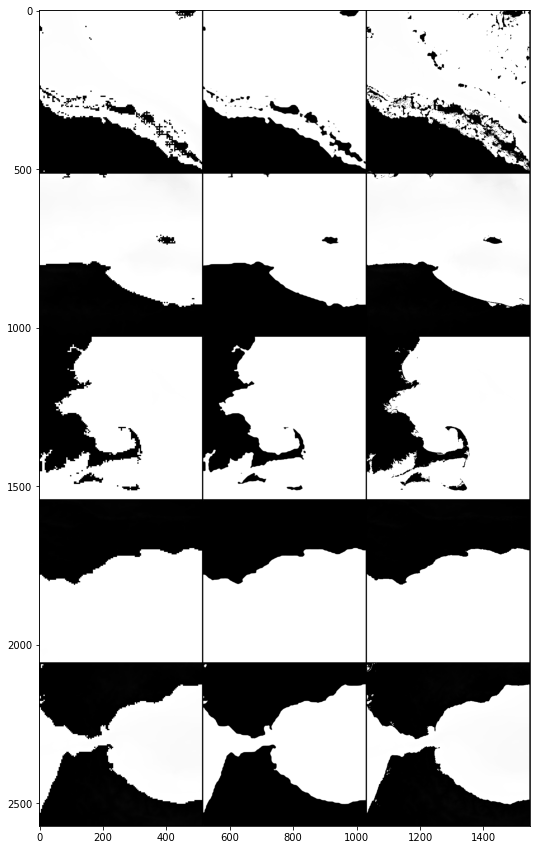

In [8]:
import matplotlib.pyplot as plt

fig, axes=plt.subplots(1,1,figsize=(9,15))
axes.imshow(img_grid.cpu().numpy()[0], cmap='gray') 